In [1]:
import xarray as xr
# OPeNDAP URL for the ESPC-D-V02 forecast (best-run aggregation)
url = "https://tds.hycom.org/thredds/dodsC/FMRC_ESPC-D-V02_ice/FMRC_ESPC-D-V02_ice_best.ncd"
ds = xr.open_dataset(url, decode_times=False)

In [2]:
ds.sst

<xarray.DataArray 'sst' (time: 361, lat: 4251, lon: 4500)> Size: 28GB
[6905749500 values with dtype=float32]
Coordinates:
  * lat       (lat) float64 34kB -80.0 -79.96 -79.92 -79.88 ... 89.92 89.96 90.0
  * lon       (lon) float64 36kB 0.0 0.07996 0.16 0.24 ... 359.8 359.8 359.9
  * time      (time) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 357.0 358.0 359.0 360.0
    time_run  (time) float64 3kB ...
Attributes:
    units:          degC
    long_name:      sea_water_temperature
    standard_name:  sea_water_temperature
    actual_range:   [-2.1290016 33.843002 ]

In [3]:
import pandas as pd
# Manually decode the time coordinate using CF metadata (units and calendar)
time_units = ds.time.attrs.get('units', '')
time_calendar = ds.time.attrs.get('calendar', 'standard')
# Split the units string (e.g. "hours since 2025-10-05 12:00:00")
if ' since ' in time_units:
    units_part, ref_date = time_units.split(' since ')
else:
    units_part = time_units
    ref_date = ''
units_part = units_part.lower()
ref_date = ref_date.strip()
# Determine frequency for pandas date_range (hourly, daily, etc.)
if 'hour' in units_part:
    freq = 'H'
elif 'day' in units_part:
    freq = 'D'
elif 'minute' in units_part:
    freq = 'T'
elif 'second' in units_part:
    freq = 'S'
else:
    # default to daily if the unit is unclear
    freq = 'D'
# Create datetime index and assign to the dataset
if 'time' in ds.coords:
    num_times = ds.sizes.get('time', None)
    if num_times is not None and ref_date:
        dates = pd.date_range(start=ref_date, periods=num_times, freq=freq)
        ds = ds.assign_coords(time=dates)

/var/folders/8f/1b9jykm565z0yjl1_pkz3tt40000gn/T/ipykernel_19454/1324729171.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(start=ref_date, periods=num_times, freq=freq)


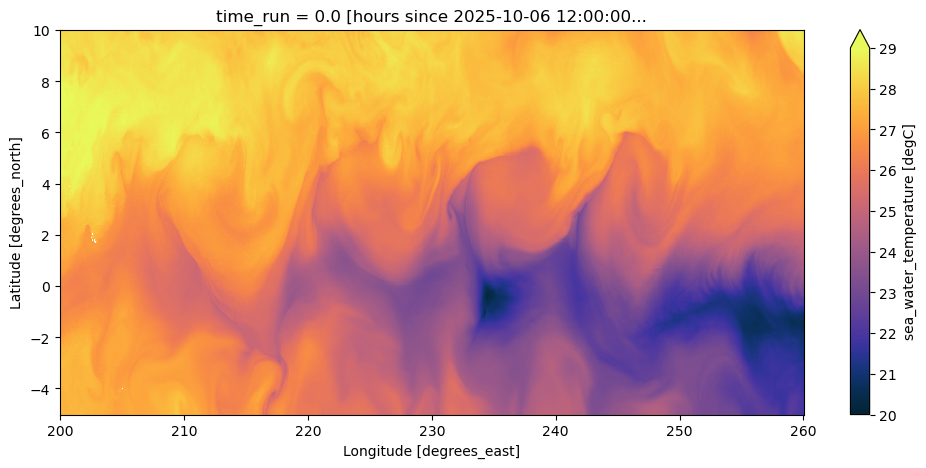

In [4]:
import cmocean.cm as cmo
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(12,5))
ds.sst.isel(time=0).sel(lat=slice(-5,10),lon=slice(200,260)).plot(ax=ax,cmap=cmo.thermal,vmin=20,vmax=29)

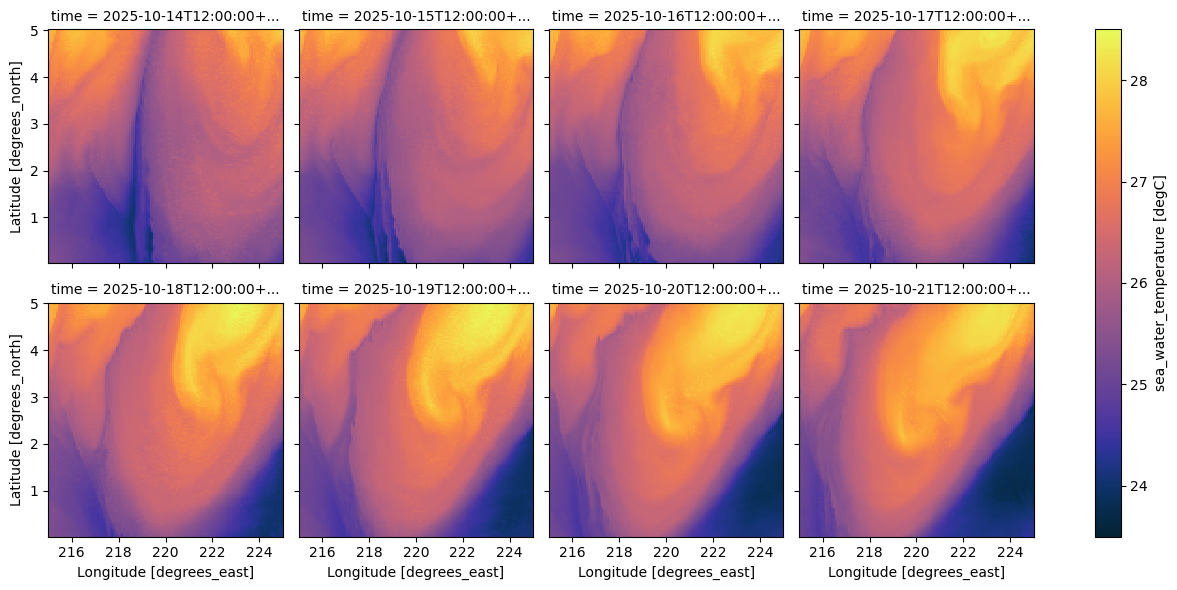

In [5]:
ds.sst.isel(time=slice(8*24,None,24)).sel(lat=slice(0,5),lon=slice(215,225)).plot(cmap=cmo.thermal,vmin=23.5,vmax=28.5,col='time',col_wrap=4)

## Animation

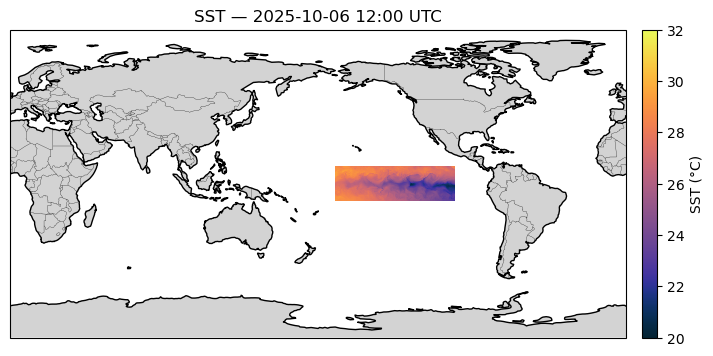

In [15]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import pandas as pd
import cmocean.cm as cmo

# LOAD FILE 
# input_file = output_file   # Your local NetCDF file
# output_file_mp4 = "sst_forecast_subset_" + start_date + ".mp4"        # Output video filename

method = 'MOTIVE'
frame_interval_hours = 1                # Frame spacing (in hours)
fps = 25

if method == 'regional':                          
    latMin = -10
    latMax = 10
    lonMin = 190
    lonMax = 260
elif method == 'MOTIVE':
    latMin = 0
    latMax = 5
    lonMin = 215
    lonMax = 225

# Subsample to region and every X hours
sst = ds.sst.sel(lat=slice(latMin, latMax), lon=slice(lonMin, lonMax))
sst = sst.isel(time=slice(0, None, frame_interval_hours)).compute()

# FIGURE SET UP 
if method == 'regional':
    output_file_mp4 = "sst_forecast_REGIONAL.mp4"
    fig = plt.figure(figsize=(10, 4))
    proj = ccrs.PlateCarree(central_longitude=180)
    ax = plt.axes(projection=proj)
    ax.set_global()
    ax.coastlines()
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.BORDERS, linewidth=0.2)  
    fixed_vmin = 20                        # Fixed color scale min (°C)
    fixed_vmax = 32                         # Fixed color scale max (°C)   
    vmin, vmax = fixed_vmin, fixed_vmax
    pcm = ax.pcolormesh(sst.lon, sst.lat, sst.isel(time=0), transform=ccrs.PlateCarree(),
                    cmap=cmo.thermal, vmin=vmin, vmax=vmax)
elif method == 'MOTIVE':
    output_file_mp4 = "sst_forecast_MOTIVE.mp4"        # Output video filename
    fig = plt.figure(figsize=(10, 4))
    ax = plt.axes()
    fixed_vmin = 23.5                        # Fixed color scale min (°C)
    fixed_vmax = 29                         # Fixed color scale max (°C)
    vmin, vmax = fixed_vmin, fixed_vmax
    pcm = ax.pcolormesh(sst.lon, sst.lat, sst.isel(time=0),
                    cmap=cmo.thermal, vmin=vmin, vmax=vmax)

cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', pad=0.02, label='SST (°C)')
title = ax.set_title(f"SST — {pd.to_datetime(sst.time[0].values):%Y-%m-%d %H:%M UTC}")

# === Animation update function ===
def update(frame):
    pcm.set_array(sst.isel(time=frame).values.ravel())
    time_str = pd.to_datetime(sst.time[frame].values).strftime("%Y-%m-%d %H:%M UTC")
    title.set_text(f"SST — {time_str}")
    return [pcm, title]

ani = animation.FuncAnimation(fig, update, frames=len(sst.time), blit=False)

# === Save animation as MP4 ===
ani.save(output_file_mp4, fps=fps, writer="ffmpeg", dpi=200)

## Save to NetCDF

In [8]:
# start_date = '2025-10-13'
# end_date = '2025-10-21'

# # Subset the dataset for the specified lat/lon box
# sst_subset = ds.sst.sel(lat=slice(latMin, latMax), lon=slice(lonMin, lonMax))
# sst_subset = sst_subset.sel(time=slice(start_date,end_date)) 

# # Save the subset to a local NetCDF file
# # Ensure time is timezone-naive before saving
# if 'time' in sst_subset.coords:
#     sst_subset['time'] = sst_subset.indexes['time'].tz_localize(None)
# output_file = "sst_forecast_subset_" + start_date + ".nc"
# sst_subset.to_netcdf(output_file)